<a href="https://colab.research.google.com/github/prtk0007/Pneumonia-Covid19-detection/blob/main/Multiclass_optimized_model-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip \*.zip

In [ ]:
import os
cpt = sum([len(files) for r, d, files in os.walk("/content/COVID-19 Radiography Database/Viral Pneumonia")])
cpt

In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio("/content/COVID-19 Radiography Database", output="Data", seed=1337, ratio=(.8, .2), group_prefix=None)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
train_path = '/content/Data/train'
#test_path = '/content/test'
valid_path = '/content/Data/val'

In [ ]:

#Define standard parameter values
batch_size = 32
img_height = 500
img_width = 500


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

image_gen = ImageDataGenerator(
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=20,
                                   horizontal_flip = True,
                                   fill_mode='nearest'
                              
                               )  

test_data_gen = ImageDataGenerator(rescale = 1./255)



train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size
                                      )

# test = test_data_gen.flow_from_directory(
#       test_path,
#       target_size=(img_height, img_width),
#       color_mode='grayscale',shuffle=False,
#       class_mode='binary',
#       batch_size=batch_size
#       )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',shuffle=False,
      class_mode='categorical', 
      batch_size=batch_size
      )

Found 3108 images belonging to 3 classes.
Found 778 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout,BatchNormalization,SeparableConv2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:
cnn = Sequential()

cnn.add(SeparableConv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(SeparableConv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(SeparableConv2D(32, (1, 1), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(SeparableConv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(SeparableConv2D(64, (1, 1), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(SeparableConv2D(128, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(SeparableConv2D(128, (1, 1), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))


cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 256))
cnn.add(Dropout(0.4))

cnn.add(Dense(activation = 'softmax', units = 3))


cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_6 (Separabl (None, 498, 498, 32)      73        
_________________________________________________________________
batch_normalization_1 (Batch (None, 498, 498, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 249, 249, 32)      0         
_________________________________________________________________
separable_conv2d_7 (Separabl (None, 247, 247, 32)      1344      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
separable_conv2d_8 (Separabl (None, 123, 123, 32)      1088      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 61, 61, 32)       

In [ ]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=4)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.1, min_lr=0.0001)

callbacks_list = [ early, learning_rate_reduction]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.0791666666666666, 1: 0.9664179104477612, 2: 0.9628252788104089}


In [ ]:
r = cnn.fit(train,epochs=30, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/30
98/98 [==============================] - 128s 969ms/step - loss: 1.0485 - accuracy: 0.3935 - val_loss: 1.0162 - val_accuracy: 0.5578
Epoch 2/30
98/98 [==============================] - 97s 985ms/step - loss: 0.6020 - accuracy: 0.7484 - val_loss: 0.9581 - val_accuracy: 0.5553
Epoch 3/30
98/98 [==============================] - 96s 978ms/step - loss: 0.5080 - accuracy: 0.7864 - val_loss: 0.6958 - val_accuracy: 0.6787
Epoch 4/30
98/98 [==============================] - 96s 976ms/step - loss: 0.4344 - accuracy: 0.8269 - val_loss: 0.4375 - val_accuracy: 0.8483
Epoch 5/30
98/98 [==============================] - 97s 982ms/step - loss: 0.3991 - accuracy: 0.8427 - val_loss: 0.4109 - val_accuracy: 0.8406
Epoch 6/30
98/98 [==============================] - 96s 977ms/step - loss: 0.3754 - accuracy: 0.8520 - val_loss: 0.4006 - val_accuracy: 0.8445
Epo

In [ ]:
cnn.evaluate(valid)

25/25 [==============================] - 9s 377ms/step - loss: 0.2068 - accuracy: 0.9293


[0.20679965615272522, 0.929305911064148]

In [ ]:
cnn.evaluate(train)

98/98 [==============================] - 74s 758ms/step - loss: 0.1898 - accuracy: 0.9318


[0.18982182443141937, 0.9317889213562012]

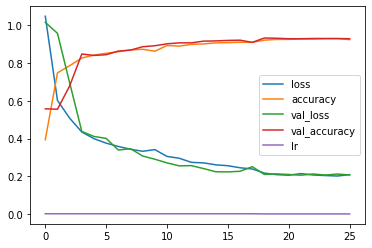

In [ ]:
pd.DataFrame(r.history).plot()

In [ ]:
%cd /content/drive/MyDrive/Kaggle

/content/drive/MyDrive/Kaggle


In [ ]:
from keras.models import load_model
cnn.save('3_class_depth_sep_acc93.h5')


In [ ]:
preds = cnn.predict(valid,verbose=1)

25/25 [==============================] - 9s 362ms/step


In [ ]:
predictions = preds.copy()
predictions = np.argmax(predictions,axis=1)
# predictions[predictions <= 0.5] = 0
# predictions[predictions > 0.5] = 1


In [ ]:
valid.classes =np.loadtxt(valid.classes, dtype='float')

TypeError: ignored

In [ ]:
print(train.class_indices)
predictions

{'COVID': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,

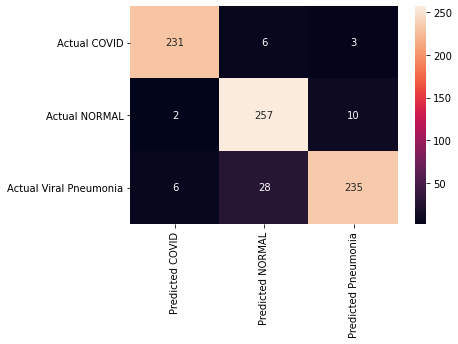

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(valid.classes, predictions, labels=[0, 1, 2]),
                  index=["Actual COVID", "Actual NORMAL", "Actual Viral Pneumonia"],
                  columns=["Predicted COVID", "Predicted NORMAL", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
 print(classification_report(y_true=valid.classes, y_pred=predictions,
                            target_names =['COVID','NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

       COVID       0.97      0.96      0.96       240
      NORMAL       0.88      0.96      0.92       269
   PNEUMONIA       0.95      0.87      0.91       269

    accuracy                           0.93       778
   macro avg       0.93      0.93      0.93       778
weighted avg       0.93      0.93      0.93       778



In [ ]:
from sklearn.metrics import roc_auc_score,plot_roc_curve,roc_curve
roc_auc_score(valid.classes, cnn.predict(valid),multi_class='ovr')

0.9860093898428047

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


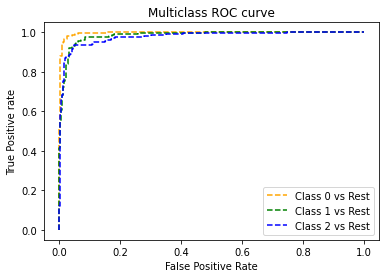

In [ ]:
fpr = {}
tpr = {}
thresh ={}

n_class = 3
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(valid.classes, cnn.predict_proba(valid)[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);    